### Importing relevant libraries:

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model
import cv2

2022-06-25 20:25:42.940131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-25 20:25:42.940161: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Creating the path for train and test data:

In [3]:
train_dir = '/home/musmanjis/Documents/Semester2/ML/ML Project/FER Dataset/train/'
test_dir = '/home/musmanjis/Documents/Semester2/ML/ML Project/FER Dataset/test/'

### Importing Data for both train and test data:

In [4]:
row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       neutral  angry  surprise  happy  disgust   sad  fear
train     4965   3995      3171   7215      436  4830  4097
      neutral  angry  surprise  happy  disgust   sad  fear
test     1233    958       831   1774      111  1247  1024


In [29]:
train_count.iloc[0].values

array([ 436, 3171, 4097, 7215, 4965, 4830, 3995])

### Plotting the frequencies of all the classes in train data:

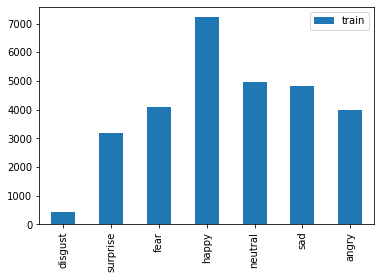

In [6]:
train_count.transpose().plot(kind='bar')
plt.show()

### Plotting the frequencies for all the classes in test data:

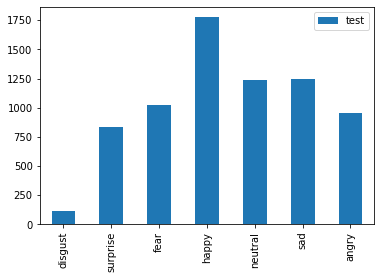

In [7]:
test_count.transpose().plot(kind='bar')
plt.show()

### List of all expressions:

In [21]:
os.listdir(train_dir)

['disgust', 'surprise', 'fear', 'happy', 'neutral', 'sad', 'angry']

### Displaying images: a small sample

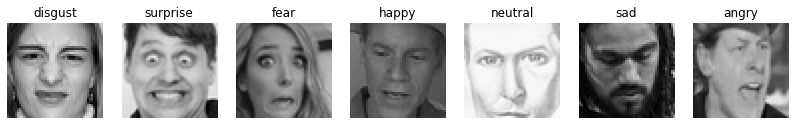

In [12]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = cv2.imread(train_dir + expression +'/'+ os.listdir(train_dir + expression)[1])
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

### Creating training and test sets:

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Indices of all classes :

In [14]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

### CNN :

In [16]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

### Summary:

In [14]:
dnet = get_model((row,col,1), classes)
dnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

/home/aravind_sundarraj0112/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Callbacks function :

In [26]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

### Training model : 

In [28]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = dnet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 4.2405 - accuracy: 0.2785
Epoch 1: val_loss improved from inf to 6.76156, saving model to ferNet.h5
448/448 [==============================] - 335s 747ms/step - loss: 4.2405 - accuracy: 0.2785 - val_loss: 6.7616 - val_accuracy: 0.1751 - lr: 1.0000e-04
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 3.4394 - accuracy: 0.3356
Epoch 2: val_loss improved from 6.76156 to 3.10898, saving model to ferNet.h5
448/448 [==============================] - 336s 747ms/step - loss: 3.4394 - accuracy: 0.3356 - val_loss: 3.1090 - val_accuracy: 0.3785 - lr: 1.0000e-04
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 2.9153 - accuracy: 0.3693
Epoch 3: val_loss improved from 3.10898 to 2.60360, saving model to ferNet.h5
448/448 [==============================] - 331s 738ms/step - loss: 2.9153 - accuracy: 0.3693 - val_loss: 2.6036 - val_accuracy: 0.4153 - lr: 1.0000e-04
Epoch 4/60
448/448 [======

Epoch 27/60
448/448 [==============================] - ETA: 0s - loss: 0.9146 - accuracy: 0.6969
Epoch 27: val_loss did not improve from 1.10136
448/448 [==============================] - 326s 727ms/step - loss: 0.9146 - accuracy: 0.6969 - val_loss: 1.1130 - val_accuracy: 0.6343 - lr: 1.0000e-04
Epoch 28/60
448/448 [==============================] - ETA: 0s - loss: 0.8902 - accuracy: 0.7030
Epoch 28: val_loss improved from 1.10136 to 1.09355, saving model to ferNet.h5
448/448 [==============================] - 329s 735ms/step - loss: 0.8902 - accuracy: 0.7030 - val_loss: 1.0936 - val_accuracy: 0.6309 - lr: 1.0000e-04
Epoch 29/60
448/448 [==============================] - ETA: 0s - loss: 0.8730 - accuracy: 0.7132
Epoch 29: val_loss did not improve from 1.09355
448/448 [==============================] - 326s 728ms/step - loss: 0.8730 - accuracy: 0.7132 - val_loss: 1.1326 - val_accuracy: 0.6363 - lr: 1.0000e-04
Epoch 30/60
448/448 [==============================] - ETA: 0s - loss: 0.8600 

448/448 [==============================] - 325s 725ms/step - loss: 0.6188 - accuracy: 0.8061 - val_loss: 1.1304 - val_accuracy: 0.6590 - lr: 1.6000e-07
Epoch 54/60
448/448 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.8068
Epoch 54: val_loss did not improve from 1.09355
448/448 [==============================] - 325s 725ms/step - loss: 0.6151 - accuracy: 0.8068 - val_loss: 1.1302 - val_accuracy: 0.6588 - lr: 1.6000e-07
Epoch 55/60
448/448 [==============================] - ETA: 0s - loss: 0.6201 - accuracy: 0.8040
Epoch 55: val_loss did not improve from 1.09355
448/448 [==============================] - 325s 725ms/step - loss: 0.6201 - accuracy: 0.8040 - val_loss: 1.1287 - val_accuracy: 0.6590 - lr: 1.6000e-07
Epoch 56/60
448/448 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.8059
Epoch 56: val_loss did not improve from 1.09355
448/448 [==============================] - 325s 726ms/step - loss: 0.6213 - accuracy: 0.8059 - val_loss: 1.12

### Loss and accuracy plot

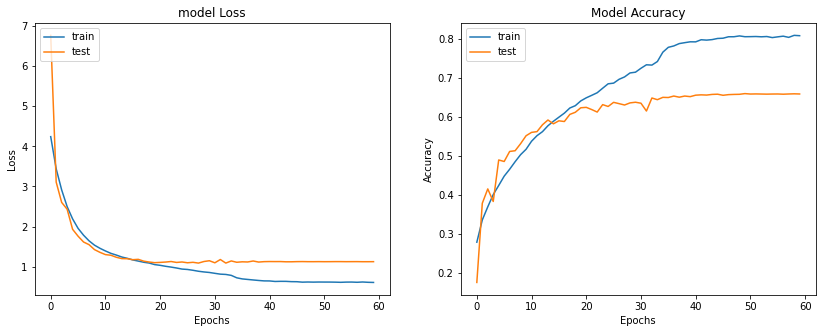

In [29]:
plt.figure(figsize=(14,5))
 
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
  

plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.show()  

### Model evaluation: 

In [30]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 11s 101ms/step - loss: 1.1288 - accuracy: 0.6592
final train accuracy = 88.27 , validation accuracy = 65.92


In [31]:
fernet.save_weights('fernet_bestweight.h5')

### Confusion Matrix and Classification on training set:

449/449 [==============================] - 46s 101ms/step
Confusion Matrix
[[ 520   44  528 1029  722  690  462]
 [  56    7   56  117   82   74   44]
 [ 536   50  548 1066  760  696  441]
 [ 948   93  932 1896 1314 1233  799]
 [ 711   69  663 1291  904  785  542]
 [ 649   79  590 1216  887  860  549]
 [ 483   40  409  805  584  495  355]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.13      0.13      3995
     disgust       0.02      0.02      0.02       436
        fear       0.15      0.13      0.14      4097
       happy       0.26      0.26      0.26      7215
     neutral       0.17      0.18      0.18      4965
         sad       0.18      0.18      0.18      4830
    surprise       0.11      0.11      0.11      3171

    accuracy                           0.18     28709
   macro avg       0.15      0.14      0.14     28709
weighted avg       0.18      0.18      0.18     28709



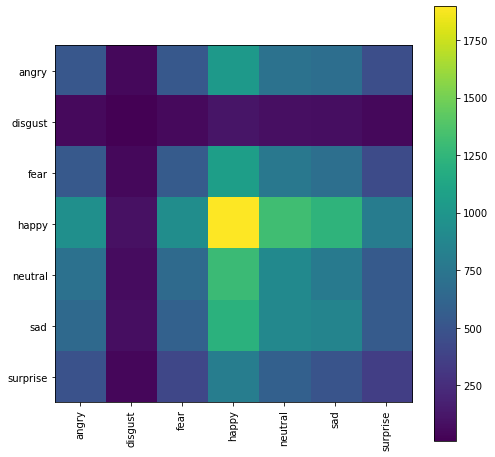

In [32]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

### Confusion matrix and classification on test set:

113/113 [==============================] - 11s 99ms/step
Confusion Matrix
[[116   5 104 244 195 169 125]
 [ 16   0  21  22  14  24  14]
 [162   9 116 241 196 182 118]
 [244  18 194 469 357 315 177]
 [179  12 121 319 247 210 145]
 [193   8 157 285 241 197 166]
 [137  15  93 202 162 138  84]]
Classification Report
              precision    recall  f1-score   support

       angry       0.11      0.12      0.12       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      0.11      0.13      1024
       happy       0.26      0.26      0.26      1774
     neutral       0.17      0.20      0.19      1233
         sad       0.16      0.16      0.16      1247
    surprise       0.10      0.10      0.10       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



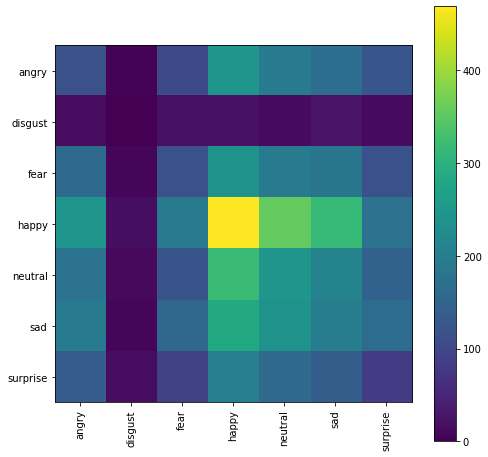

In [33]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)